In [0]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
# Download the dataset
!git clone https://github.com/AlessioGalluccio/GuyaPredictor

fatal: destination path 'GuyaPredictor' already exists and is not an empty directory.


In [0]:
!mkdir training
%cd training
!mkdir Kaguya
!mkdir NotKaguya
%cd ..
!mkdir validation
%cd validation
!mkdir Kaguya
!mkdir NotKaguya
%cd ..

mkdir: cannot create directory ‘training’: File exists
/content/training
mkdir: cannot create directory ‘Kaguya’: File exists
mkdir: cannot create directory ‘NotKaguya’: File exists
/content
mkdir: cannot create directory ‘validation’: File exists
/content/validation
mkdir: cannot create directory ‘Kaguya’: File exists
mkdir: cannot create directory ‘NotKaguya’: File exists
/content


In [0]:
import os
import shutil

#copy kaguya images training in training/Kaguya
path_kaguya = 'GuyaPredictor/KaguyaMangaPages'
kaguya_images = sorted(os.listdir(path_kaguya))
for image in kaguya_images:
  shutil.copyfile(os.path.join(path_kaguya, image), os.path.join('training/Kaguya', image))

#copy notKaguya images training in training/NotKaguya
path_notKaguya = 'GuyaPredictor/NotKaguyaMangaPages'
notKaguya_images = sorted(os.listdir(path_notKaguya))
for image in notKaguya_images:
  shutil.copyfile(os.path.join(path_notKaguya, image), os.path.join('training/NotKaguya', image))

In [0]:
def copyImagesFromDirToDir(path_source, path_dest, add_character_prefix = ''):
  images = sorted(os.listdir(path_source))
  for image in images:
    shutil.copyfile(os.path.join(path_source, image), os.path.join(path_dest, add_character_prefix + image))

# ImageGenerator

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

SEED = 42

train_path = '/content/training'
validation_path = '/content/validation'

bs = 16
image_x = 850
image_y = 1300
#image_size = 224
num_class = len(os.listdir(train_path))

lista = os.listdir(train_path)
lista.sort()

image_datagen = ImageDataGenerator(rescale=1./255,
                                     validation_split=0.2)


train_generator = image_datagen.flow_from_directory(
                        directory= train_path,
                        subset= 'training',
                        target_size=(image_x,image_y),
                        batch_size=bs,
                        classes = lista,
                        color_mode='rgb',
                        shuffle=True,
                        class_mode='binary',
                        seed = SEED)

validation_generator = image_datagen.flow_from_directory(
                        directory= train_path,
                        subset= 'validation',
                        target_size=(image_x,image_y),
                        batch_size=bs,
                        save_to_dir= validation_path, #TODO doesn't work
                        classes = lista,
                        color_mode='rgb',
                        shuffle=True,
                        class_mode='binary',
                        seed = SEED)

Found 191 images belonging to 2 classes.
Found 46 images belonging to 2 classes.


In [0]:
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, image_x, image_y, 3], [None, num_class]))
train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, image_x, image_y, 3], [None, num_class]))

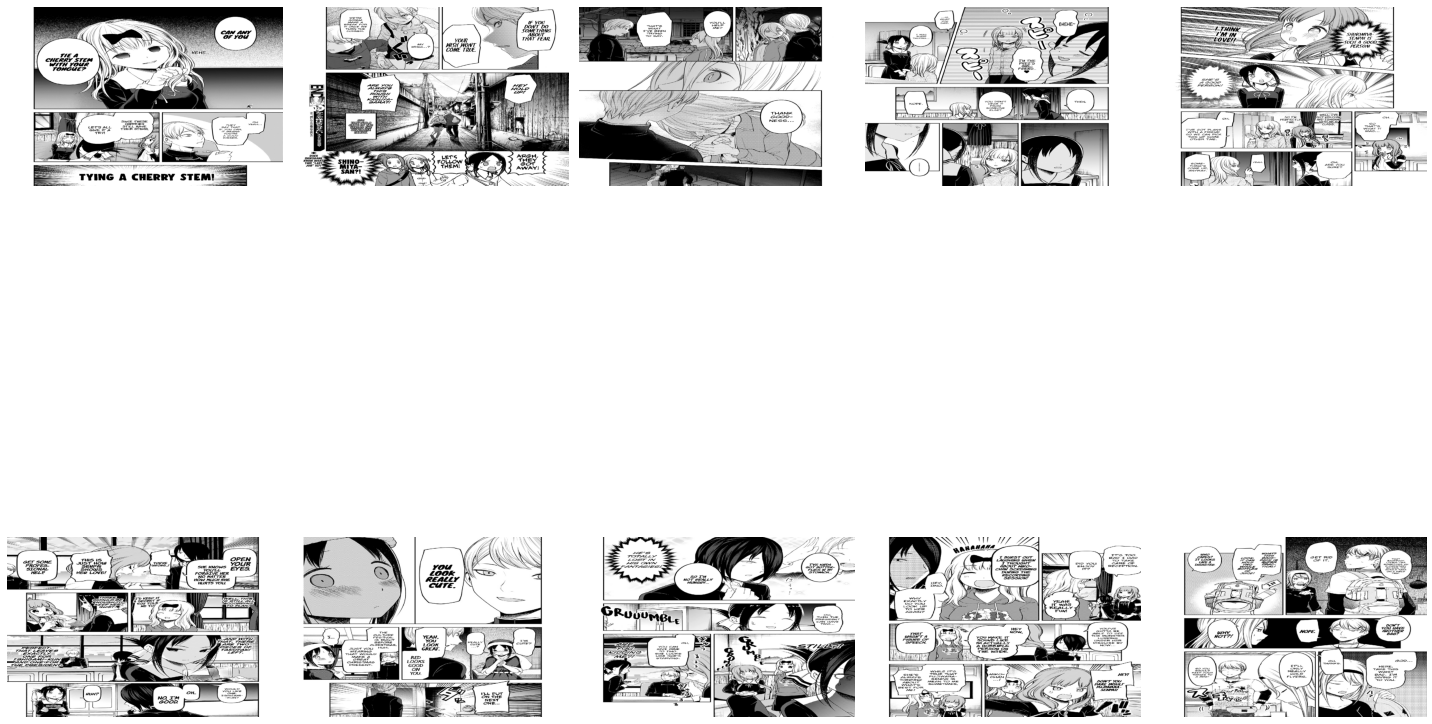

In [0]:
import matplotlib.pyplot as plt

sample_training_images, _ = next(train_generator)

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(2, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:10])

In [0]:
train_generator.class_indices

{'Kaguya': 0, 'NotKaguya': 1}

# Model

In [0]:
import tensorflow.keras.layers as layers

model = tf.keras.models.Sequential()
model.add(layers.Conv2D(4, (3, 3), activation='relu', input_shape=(image_x, image_y, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(4, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(8, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(8, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 848, 1298, 4)      112       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 424, 649, 4)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 422, 647, 4)       148       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 211, 323, 4)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 209, 321, 8)       296       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 104, 160, 8)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 102, 158, 8)       5

In [0]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.BinaryCrossentropy()

# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [0]:
train_generator.samples

191

In [0]:
import os
from datetime import datetime

# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'classification_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    callbacks.append(es_callback)

model.fit(x=train_generator,
          epochs=30,  #### set repeat in training dataset
          steps_per_epoch=int(np.ceil(len(train_generator))),
          validation_data=validation_generator,
          validation_steps=int(np.ceil(len(validation_generator))),
          callbacks=callbacks)

Epoch 1/30
12/12 [==============================] - 16s 1s/step - loss: 0.7007 - accuracy: 0.5079 - val_loss: 0.6885 - val_accuracy: 0.5870
Epoch 2/30
12/12 [==============================] - 15s 1s/step - loss: 0.6839 - accuracy: 0.5864 - val_loss: 0.6841 - val_accuracy: 0.5652
Epoch 3/30
12/12 [==============================] - 15s 1s/step - loss: 0.6760 - accuracy: 0.5969 - val_loss: 0.6721 - val_accuracy: 0.6087
Epoch 4/30
12/12 [==============================] - 15s 1s/step - loss: 0.6668 - accuracy: 0.5969 - val_loss: 0.6708 - val_accuracy: 0.5870
Epoch 5/30
12/12 [==============================] - 15s 1s/step - loss: 0.6584 - accuracy: 0.5654 - val_loss: 0.6369 - val_accuracy: 0.6522
Epoch 6/30
12/12 [==============================] - 15s 1s/step - loss: 0.5983 - accuracy: 0.6230 - val_loss: 0.6844 - val_accuracy: 0.5870
Epoch 7/30
12/12 [==============================] - 15s 1s/step - loss: 0.5357 - accuracy: 0.7277 - val_loss: 0.6895 - val_accuracy: 0.6087
Epoch 8/30
12/12 [==

In [0]:
model.save('GuyaPredictor.h5') 

In [0]:
#voglio vedere le predizioni sul validation set
test_datagen = ImageDataGenerator(rescale=1./255)



test_generator = test_datagen.flow_from_directory(directory='validation',
                              # only read images from `test` directory
                              # don't generate labels
                              classes=['iceguya'],
                              class_mode=None,
                              # don't shuffle
                              shuffle=False,
                              # use same size as in training
                              target_size=(image_x, image_y))


pred = model.predict(x=train_generator,
              callbacks = callbacks,
              steps = len(train_generator),
              verbose = 1)
pred

Found 0 images belonging to 1 classes.
12/12 [==============================] - 6s 472ms/step


array([[0.37141395],
       [0.37165445],
       [0.34976113],
       [0.36880285],
       [0.46857974],
       [0.354474  ],
       [0.35312548],
       [0.36471793],
       [0.2649941 ],
       [0.42326057],
       [0.36009088],
       [0.33025977],
       [0.37769294],
       [0.402707  ],
       [0.35878423],
       [0.37894696],
       [0.3421494 ],
       [0.41429725],
       [0.4441686 ],
       [0.3395455 ],
       [0.43890542],
       [0.3449996 ],
       [0.4734455 ],
       [0.38393337],
       [0.37808186],
       [0.42828685],
       [0.35784566],
       [0.47793588],
       [0.38171366],
       [0.33841994],
       [0.4827987 ],
       [0.4632788 ],
       [0.41317403],
       [0.37259856],
       [0.4206723 ],
       [0.45745653],
       [0.32882673],
       [0.38569573],
       [0.41490814],
       [0.36561915],
       [0.4212894 ],
       [0.4553024 ],
       [0.37084708],
       [0.42368963],
       [0.3737322 ],
       [0.33315787],
       [0.40785185],
       [0.379

In [0]:
from PIL import Image
import numpy as np
image = Image.open('142_18.png')
# convert image to numpy array
data = np.asarray(image)
data = np.resize(data, (image_x, image_y, 3))
data = np.expand_dims(data, axis=0)

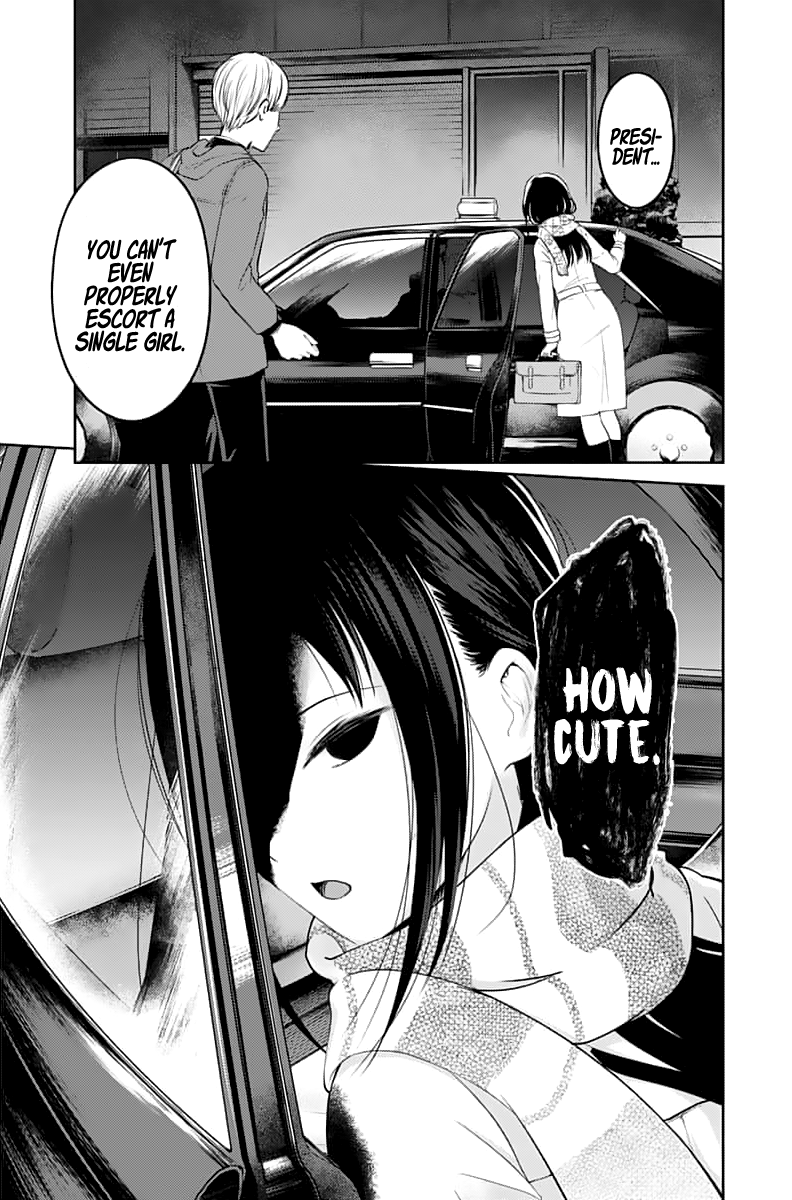

In [0]:
image

In [0]:
data.shape

In [0]:
x = model.predict(data)

In [0]:
x